In [ ]:
!conda install transformers -y


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer


In [ ]:
# Check if APPLE MPS is working
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(300, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

In [ ]:
# Ensuring that pytorch installation is using Metal Performance Shaders
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())


In [ ]:
!conda install git+https://github.com/philipturner/metal-flash-attention.git


In [ ]:
# Load the model and tokenizer
model_name = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map = "mps",
    torch_dtype = "auto",
    trust_remote_code = True,
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

In [ ]:
prompt = """Write an email apologizing  to Sarah for the tragic gardening mishap.
Explain how it happened. <|assistant|>\n"""

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("mps")


In [ ]:
# Generate the text
generation_output = model.generate(
    input_ids = input_ids,
    max_new_tokens = 20
)

# Print the output
print(tokenizer.decode(generation_output[0]))

In [ ]:
# Printing the tokens generated from Input string
print(input_ids)

In [ ]:
# Seeing each token individually
for id in input_ids[0]:
    print(tokenizer.decode(id))

In [ ]:
# Printing the output tokens also
print(generation_output)

In [ ]:
# Decoding individual Tokenizers -> Just for fun
print(tokenizer.decode(406))
print(tokenizer.decode([6225, 363, 19906]))

In [ ]:
colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]


In [ ]:
def show_tokens(sentence, tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    token_ids = tokenizer(sentence).input_ids
    for idx,t in enumerate(token_ids):
        print(f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m'+
                 tokenizer.decode(t) + 
              '\x1b[0m', 
              end=' '
             )

In [ ]:
show_tokens(prompt, model_name)

## Creating Contextualized Word Embeddings with Language Models

The model we’re using here is called DeBERTa v3, which at the time of writing is one of the best-performing language models for token embeddings while being small and highly efficient. It is described in the paper <a href = "https://oreil.ly/3Piya"> “DeBERTaV3: Improving DeBERTa using ELECTRA-style pre-training gradient-disentangled embedding sharing”. </a>

In [ ]:
from transformers import AutoModel, AutoTokenizer


In [ ]:
# Load a Tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

In [ ]:
# Load a language Model
model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall")

In [ ]:
# Tokenize the sentence
tokens = tokenizer('Hello World', return_tensors = 'pt')

In [ ]:
# Process the tokens
output = model(**tokens)[0]

In [ ]:
# Inspecting the variables by first printing it's dimensions
output.shape

In [ ]:
# Seeing every tokens clearly
for token in tokens['input_ids'][0]:
    print(tokenizer.decode(token), " -> " , token)

## Text Embeddings (for Sentences and Whole Documents)
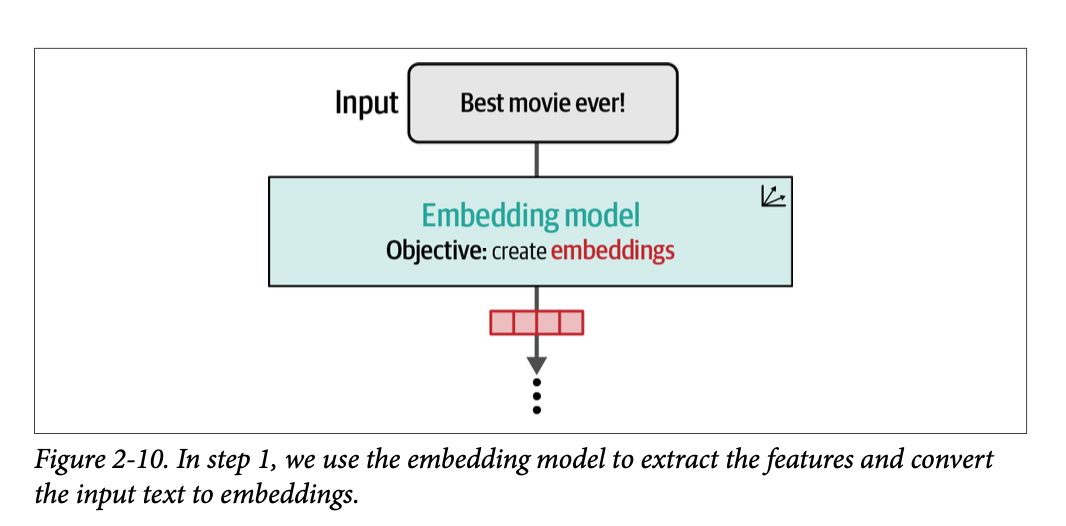

- One of the most common ways of producing text embedding vector is to average the values of all the token embeddings produced by the model. Yet high-quality text embedding models tend to be trained specifically for text embedding tasks.

- We will produce text embeddings with `sentence-transformers`, a popular package for leveraging pretrained embedding models.1 The package, like `transformers` can be used to load publicly available models. 

- we use the `all-mpnet-base-v2 model`.

In [ ]:
from sentence_transformers import SentenceTransformer


In [ ]:
# Load model 
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


In [ ]:
# Convert text to text embeddings
vector = model.encode("Best Movie Ever!!")

In [ ]:
vector.shape

## Using PreTrained Word Embeddings
we can download pretrained word embeddings (like word2vec or
GloVe) using the <a href="https://oreil.ly/M8wi8">Gensim library</a>

In [ ]:
!conda install -c conda-forge gensim -y

In [ ]:
import gensim
print(gensim.__version__)

In [ ]:
import gensim.downloader as api

In [ ]:
# Download embeddings (66MB, glove, trained on wikipedia, vector size: 50)
# Other options include "word2vec-google-news-300"
# More options at https://github.com/RaRe-Technologies/gensim-data

model = api.load("glove-wiki-gigaword-50")

In [ ]:
model.most_similar([model['king']], topn=11)

## Word2Vec Algorithm and Contrastive Training
- The word2vec algorithm described in the paper <a href="https://oreil.ly/nLDeS">“Efficient estimation of word representations in vector space”</a> is described in detail in <a href="https://oreil.ly/ybd-K">The Illustrated Word2vec</a>.

# Embeddings for Recommendation Systems
## Recommending Songs by Embeddings (Training a Song Embedding Model)
- we’ll use the word2vec algorithm to embed songs using human-made
music playlists.
- The <a href="https://oreil.ly/A-AK6">dataset</a> we’ll use was collected by Shuo Chen from Cornell University. It contains playlists from hundreds of radio stations around the US.

Sample Working of the system :
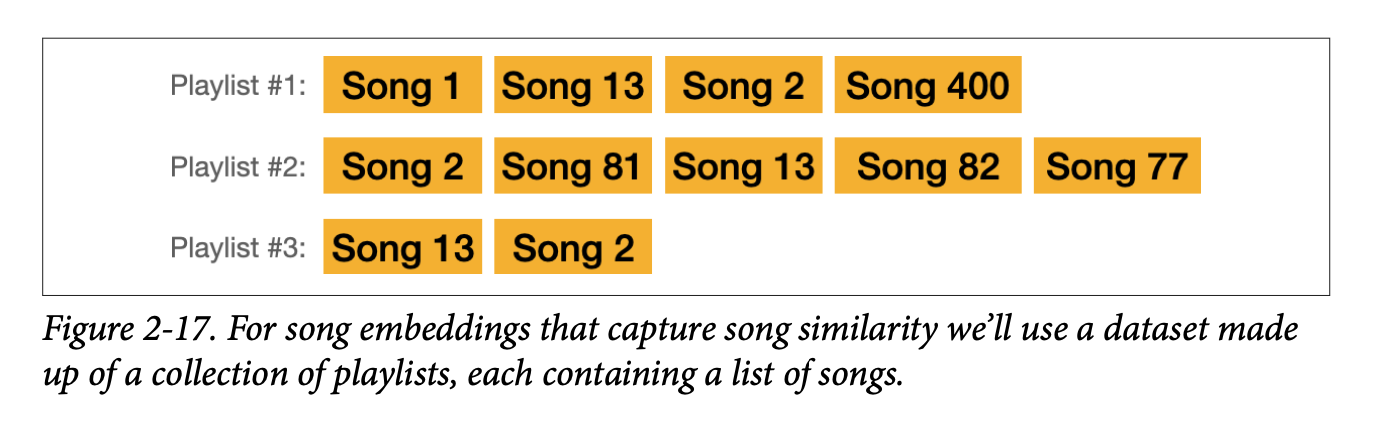
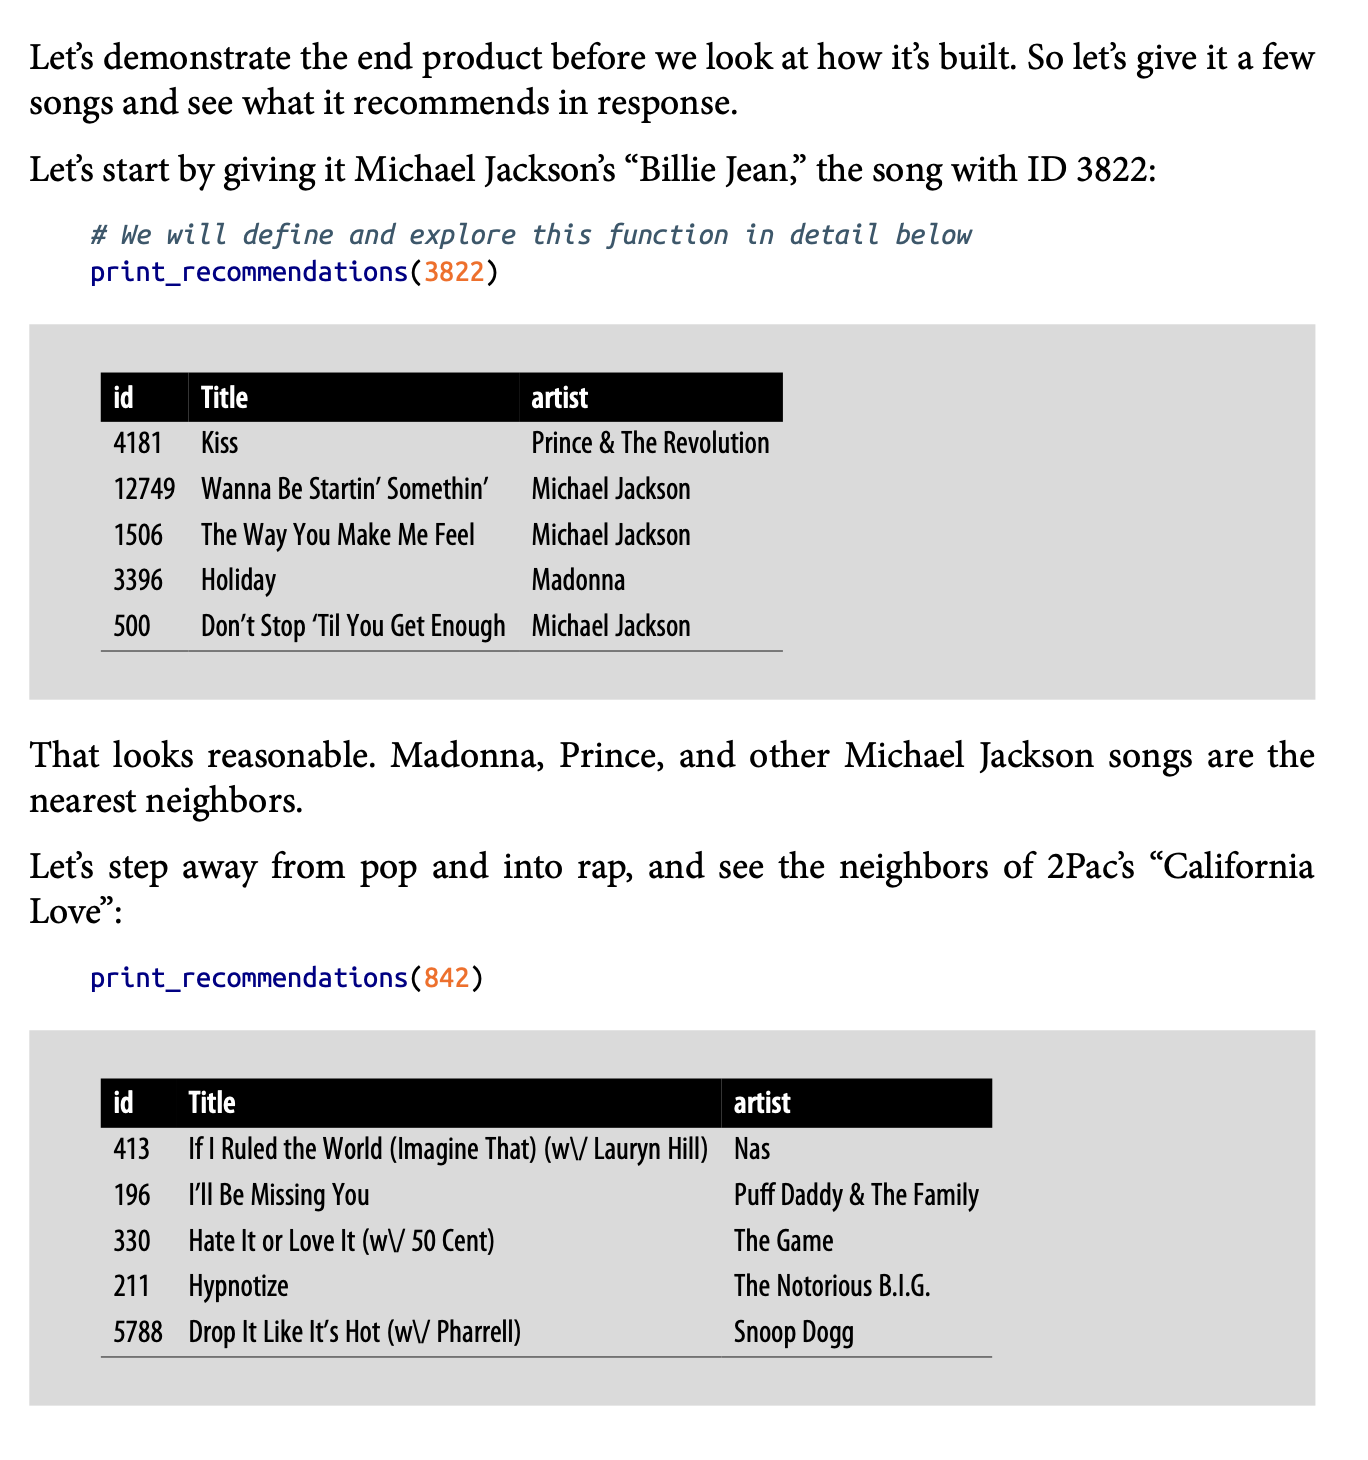


1. Load the Dataset containing the song playlists as well as each song's metadata, such as title and artist

In [ ]:
import pandas as pd
from urllib import request

In [ ]:
# import urllib.request
try:
    # Test with a known working URL
    response = request.urlopen('https://www.google.com')
    print("Success", response.status)
except Exception as e:
    print("Error: ",e)

In [ ]:
# Get the playlist dataset file
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

In [ ]:
# Parse the playlist dataset file. Skip the first two lines as they only contain metadata
lines = data.read().decode('utf-8').split('\n')[2:]

# Remove playlists with only one song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]

# Load the song metadata
songs_file = request.urlopen("https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt")
songs_file = songs_file.read().decode('utf-8').split('\n')

songs = [s.rstrip().split('\t') for s in songs_file]

songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

2. Let's inspect the `playlists` list. Each element inside it is a playlist containing a list of song IDs.

In [ ]:

print('Playlist #1: ', playlists[0], '\n')
print('Playlist #2: ', playlists[1], "\n")

3. Let's train the model

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Train our Word2Vec model
model = Word2Vec(
    playlists,
    vector_size=32,
    window=20,
    negative=50,
    min_count=1,
    workers=4
)

Note: This takes a minute or two to train and results in embeddings being calculated for each song that we have. Now we can use those embeddings to find similar songs exactly as we did earlier with words.

In [ ]:
song_id = 2172

# To see the current song with the song_id
print(songs_df.iloc[2172])

In [ ]:
# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

4. Get the actual list of songs name from the recommender system

In [ ]:
import numpy as np

In [ ]:
def print_recommendations(song_id):
    similar_songs = np.array(
        model.wv.most_similar(positive=str(song_id), topn=5)
    )[:,0]
    return songs_df.iloc[similar_songs]

In [ ]:
# Extract recommendations
print_recommendations(song_id)